Getting started with NLP - Beginners

In [1]:
!pip install kaggle

In [2]:
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()

Using Kaggle data on your own machine

In [7]:
path = Path('us-patent-phrase-to-phrase-matching')
!chmod 600 /root/.config/kaggle/kaggle.json

In [13]:
if not path.exists():
  import zipfile,kaggle
  kaggle.api.competition_download_cli(str(path))
  zipfile.ZipFile(f'{path}.zip').extractall(path)
  #!kaggle competitions download -c us-patent-phrase-to-phrase-matching

100%|██████████| 682k/682k [00:00<00:00, 361MB/s]

Import and EDA

In [14]:
!ls {path}

sample_submission.csv  test.csv  train.csv


In [15]:
import pandas as pd

In [16]:
df = pd.read_csv(path/'train.csv')

In [17]:
df.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [18]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,8d135da0b55b8c88,component composite coating,composition,H01
freq,1,152,24,2186


In [19]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor

In [20]:
df.input.head()

,input
0,TEXT1: A47; TEXT2: abatement of pollution; ANC...
1,TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2,TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3,TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4,TEXT1: A47; TEXT2: forest region; ANC1: abatement


Tokenization

Transformers uses a Dataset object for storing a... well a dataset, of course! We can create one like so:

In [21]:
from datasets import Dataset,DatasetDict

ds = Dataset.from_pandas(df)

In [22]:
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

In [23]:
model_nm = 'microsoft/deberta-v3-small'

AutoTokenizer will create a tokenizer appropriate for a given model:

In [24]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Here's an example of how the tokenizer splits a text into "tokens" (which are like words, but can be sub-word pieces, as you see below):

In [25]:
tokz.tokenize("G'day folks, I'm Jeremy from fast.ai!")

['▁G',
 "'",
 'day',
 '▁folks',
 ',',
 '▁I',
 "'",
 'm',
 '▁Jeremy',
 '▁from',
 '▁fast',
 '.',
 'ai',
 '!']

In [26]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['▁A',
 '▁platypus',
 '▁is',
 '▁an',
 '▁or',
 'ni',
 'tho',
 'rhynch',
 'us',
 '▁an',
 'at',
 'inus',
 '.']

Here's a simple function which tokenizes our inputs:

In [27]:
def tok_func(x): return tokz(x["input"])

To run this quickly in parallel on every row in our dataset, use map:

In [28]:
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

This adds a new item to our dataset called input_ids. For instance, here is the input and IDs for the first row of our data:

In [29]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

So, what are those IDs and where do they come from? The secret is that there's a list called vocab in the tokenizer which contains a unique integer for every possible token string. We can look them up like this, for instance to find the token for the word "of":

In [30]:
tokz.vocab['▁of']

265

Finally, we need to prepare our labels. Transformers always assumes that your labels has the column name labels, but in our dataset it's currently score. Therefore, we need to rename it:

In [31]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

Test and validation sets

In [32]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,hybrid bearing,inorganic photoconductor drum,G02
freq,1,2,1,3


Validation set¶

To explain the motivation, let's start simple, and imagine we're trying to fit a model where the true relationship is this quadratic:

In [33]:
def f(x): return -3*x**2 + 2*x + 20

Unfortunately matplotlib (the most common library for plotting in Python) doesn't come with a way to visualize a function, so we'll write something to do this ourselves:

In [34]:
import numpy as np, matplotlib.pyplot as plt

def plot_function(f, min=-2.1, max=2.1, color='r'):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)

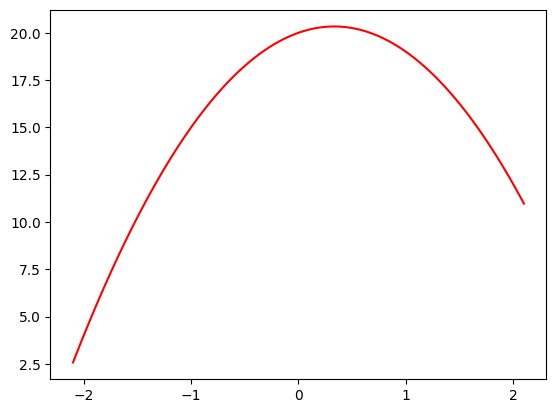

In [35]:
plot_function(f)

For instance, perhaps we've measured the height above ground of an object before and after some event. The measurements will have some random error. We can use numpy's random number generator to simulate that. I like to use seed when writing about simulations like this so that I know you'll see the same thing I do

In [36]:
from numpy.random import normal,seed,uniform
np.random.seed(42)
def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

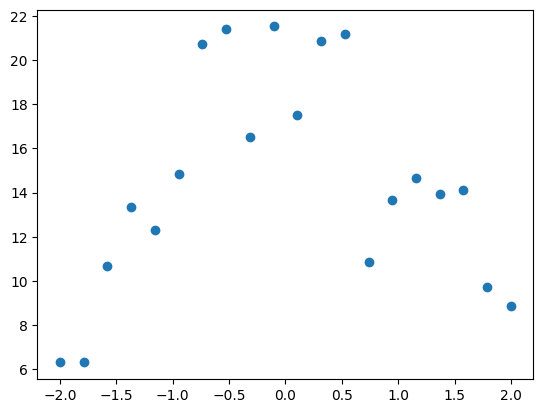

In [37]:
x = np.linspace(-2, 2, num=20)[:,None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x,y);

Now let's see what happens if we underfit or overfit these predictions.

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x,y)
    plot_function(model.predict)

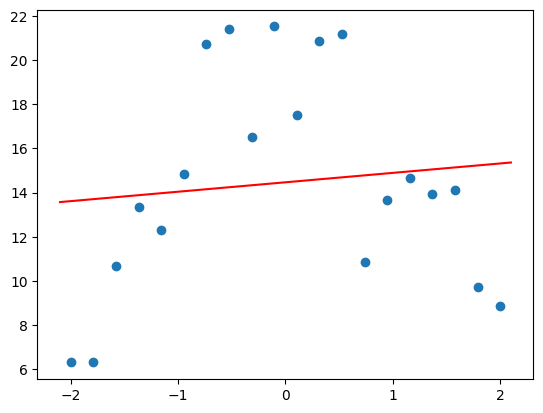

In [39]:
# So, what happens if we fit a line (a "degree 1 polynomial") to our measurements?
plot_poly(1)

As you see, the points on the red line (the line we fitted) aren't very close at all. This is under-fit -- there's not enough detail in our function to match our data.

And what happens if we fit a degree 10 polynomial to our measurements?

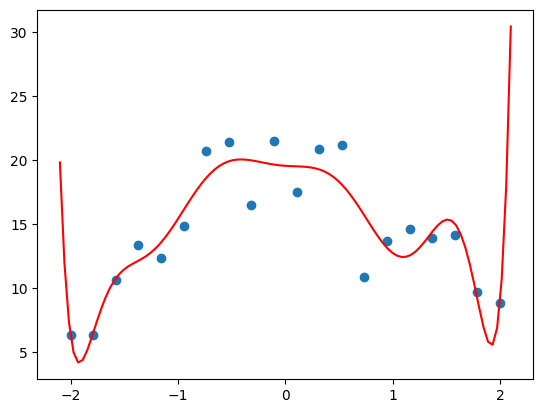

In [40]:
plot_poly(10)

Well now it fits our data better, but it doesn't look like it'll do a great job predicting points other than those we measured -- especially those in earlier or later time periods. This is over-fit -- there's too much detail such that the model fits our points, but not the underlying process we really care about.

Let's try a degree 2 polynomial (a quadratic), and compare it to our "true" function (in blue)

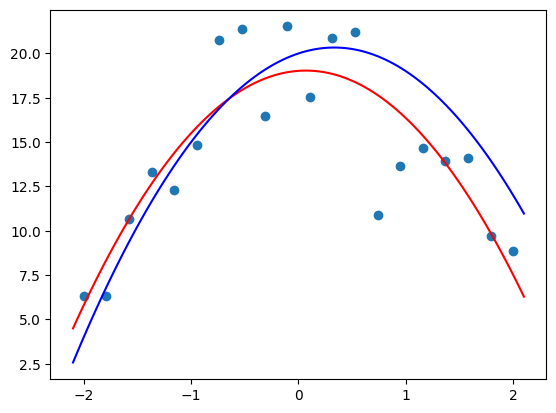

In [41]:
plot_poly(2)
plot_function(f, color='b')

That's not bad at all!

So, how do we recognise whether our models are under-fit, over-fit, or "just right"? We use a validation set. This is a set of data that we "hold out" from training -- we don't let our model see it at all.

Transformers uses a DatasetDict for holding your training and validation sets. To create one that contains 25% of our data for the validation set, and 75% for the training set, use train_test_split:

In [42]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

Test set

In [44]:
#We'll use eval as our name for the test set, to avoid confusion with the test dataset that was created above.
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Metrics and correlation¶